# SYSM6302 - Lab 4
Jonas Wagner, jrw200000

In [1]:

import networkx as nx
from numpy import *  # WHY!
import matplotlib.pyplot as plt
plt.ioff()
import sys
sys.path.append('../d3networkx/')
import d3networkx as d3nx
from d3graph import D3Graph, D3DiGraph
import asyncio
import random
import randomnet

The `randomnet` import statement provides functions to build local attachment and small world random networks. This small world network is slightly different from the version that is implemented in NetowrkX.

## Section 15.1.0: Small World Networks

This function generates a small world network, where `n` nodes are connected to `q` neighboring nodes "around the circle" and with probability `p` to all other nodes. Even though the `randomnet.py` file contains a very similar function, this version has some extra code to lay out the network in an intuitive way (with the nodes in a circle).

In [2]:
async def small_world(n,q,p,G=None,d3=None,x0=300,y0=300):
    '''
    q must be even
    '''
    if d3:
        d3.set_interactive(False)
    if G is None:
        G = D3Graph()
    for i in range(n):
        G.add_node(i)
        if d3:
            x = 200*cos(2*pi*i/n) + x0
            y = 200*sin(2*pi*i/n) + y0
            d3.position_node(i,x,y)
    # add the regular edges
    for u in range(n):
        for v in range(u+1,int(u+1+q/2)):
            v = v % n
            G.add_edge(u,v)

    if d3:
        d3.update()
        await asyncio.sleep(3)
        d3.set_interactive(True)

    # add the random edges
    for u in range(n):
        for v in range(u+1,n):
            if not G.has_edge(u,v):
                if random.random() <= p:
                    G.add_edge(u,v)

    return G

In [3]:
d3 = await d3nx.create_d3nx_visualizer()

websocket server started...networkx connected...

Now with the visualizer running, we will visualize a small world network

In [4]:
G = D3Graph()
d3.set_graph(G)
G = await small_world(20,4,0.1,G,d3)

visualizer connected...

#### Diameter Observations
The original circular network appeared to have a diameter of approximently half the circle (so like 10) but when the random edges are added it dramatically decreased to around 3.

#### Diameter Calculation

Now let's plot the convergence of the small world effect.

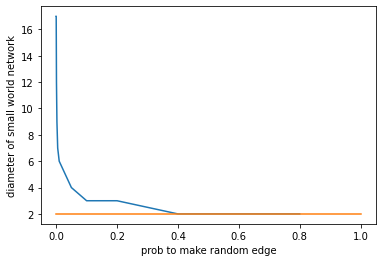

In [5]:
n = 100
P = [0,0.0001,0.001,0.0025,0.005,0.01,0.05,0.1,0.2,0.4,0.6,0.8]
x = []
y = []
for i, p in enumerate(P):
    G = randomnet.small_world_graph(n,6,p)
    x.append(p)
    y.append(nx.diameter(G))
    # calculate the diameter and store it for plotting below

## Plot the Convergence
plt.figure()
plt.plot(x,y)
plt.plot([0.0001,1],[(log10(n)),(log10(n))])
plt.xlabel('prob to make random edge')
plt.ylabel('diameter of small world network')
plt.show()

The addition of random edges being added to the network would add an additional path between nodes and in the best case, take the path that made up the original diameter and turn it to 2. If you randomly do this enough, there will eventlly make every node connected.

## Section 8.1-8.4.14: Fitting Power Law

The following helper functions provide easy access to the degree sequence and the degree and cumulative degree distributions.

In [6]:
def degree_sequence(G):
    return [d for n, d in G.degree()]

def degree_distribution(G,normalize=True):
    deg_sequence = degree_sequence(G)
    max_degree = max(deg_sequence)
    ddist = zeros((max_degree+1,))
    for d in deg_sequence:
        ddist[d] += 1
    if normalize:
        ddist = ddist/float(G.number_of_nodes())
    return ddist

def cumulative_degree_distribution(G):
    ddist = degree_distribution(G)
    cdist = [ ddist[k:].sum()  for k in range(len(ddist)) ] 
    return cdist

The following function, which you must complete, plots the degree distribution and calculates the power law coefficient, $\alpha$.

In [7]:
def calc_powerlaw(G,kmin=None,axes = [], titleAdd = ' '):
    ddist = degree_distribution(G,normalize=False)
    cdist = cumulative_degree_distribution(G)
    k = arange(len(ddist))
    
    N = sum(ddist[kmin:k[-1]])
    ksum = 0
    for i in k[kmin:-1]:
        ksum += ddist[i] * log(i/(kmin-0.5))
    alpha = 1 + N * (ksum) ** -1
    sigma = (alpha - 1) / sqrt(N)
    alphaValue = ('alpha = %1.2f +/- %1.2f' % (alpha,sigma))
    print(alphaValue)
    
    # Assign Values for Ploting
    xvalues = k;
    barheights = ddist # Degree Dist
    yvalues = cdist; # Cumulative Dist
    
    if size(axes) == 0:
        fig, axes = plt.subplots(2,1,figsize=(8,12))
    # Plot Degree Dist
#     plt.figure(figsize=(8,12))
#     plt.subplot(211)
    axes[0].bar(xvalues,barheights, width=0.8, bottom=0, color='b')
    plt.autoscale('True')
    
    # Plot cdist
#     plt.subplot(212)
    axes[1].loglog(xvalues,yvalues)
    plt.grid(True)
    
    axes[0].set_title([titleAdd,'kmin = ', str(kmin),alphaValue])
    return alpha
    

#### Degree Distribution calculation and ploting

alpha = 1.61 +/- 0.01


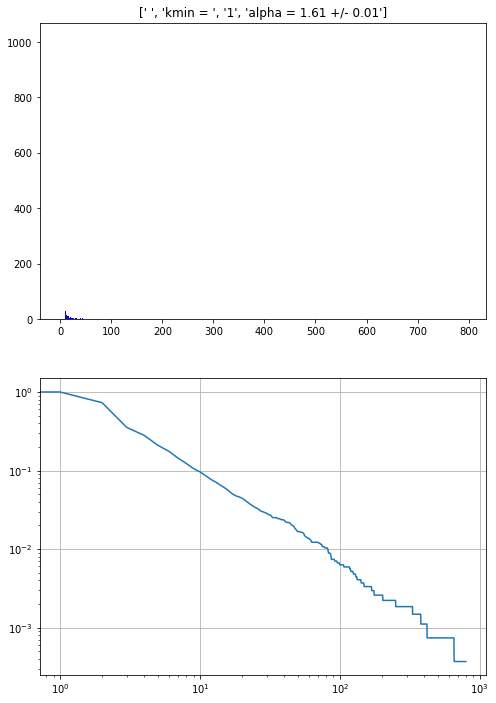

In [8]:
# japanese.edgelist
kmin = 1
G = nx.read_weighted_edgelist('japanese.edgelist',create_using=nx.DiGraph)
calc_powerlaw(G,kmin) # select kmin!
plt.show()

alpha = 4.14 +/- 0.16


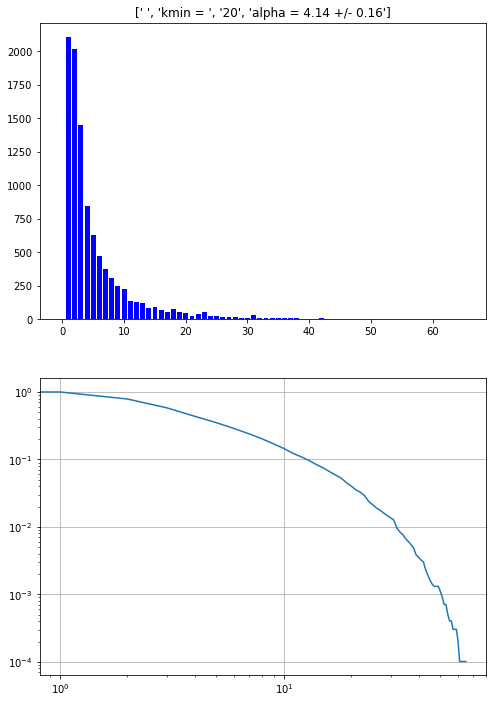

In [9]:
# ca-HepTh.edgelist
kmin = 20
G = nx.read_weighted_edgelist('ca-HepTh.edgelist',create_using=nx.Graph)
calc_powerlaw(G,kmin) # select kmin!
plt.show()

alpha = 1.55 +/- 0.00


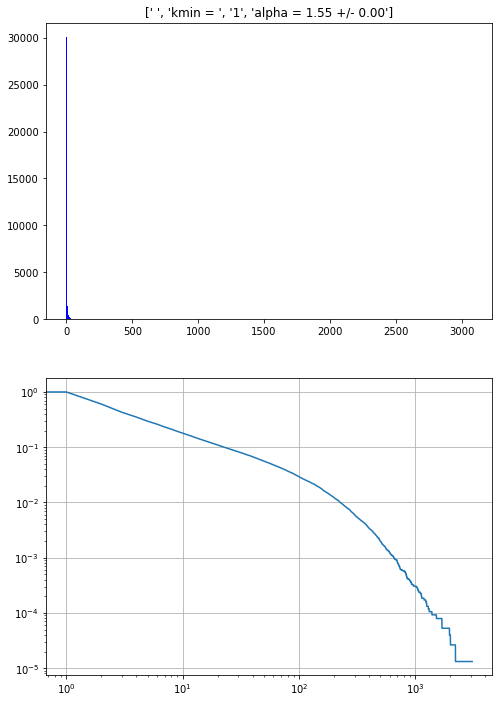

In [10]:
# soc-Epinions1.edgelist
kmin = 1
G = nx.read_weighted_edgelist('soc-Epinions1.edgelist',create_using=nx.DiGraph)
calc_powerlaw(G,kmin) # select kmin!
plt.show()

## Section 12-12.5: Giant Component

Testing of the functions

In [11]:
n = 50
p = 0.01
G = nx.erdos_renyi_graph(n,p)
cc_max_size = len(max(nx.connected_components(G),key=len))

Plotting Figure 12.1

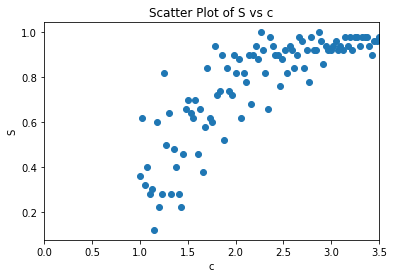

In [12]:
N = [50]#range(50,75)
# P = linspace(0,1,5)
C = linspace(1,3.5,100)
S = []
# C = []
fig, ax = plt.subplots()
for n in N:
    S = []
    for c in C:
        p = c / (n-1)
        G = nx.erdos_renyi_graph(n,p)
        cc_max_size = len(max(nx.connected_components(G),key=len))
        S.append(cc_max_size/n)
    ax.scatter(C,S)
    
plt.xlim(0,3.5)
plt.title('Scatter Plot of S vs c')
plt.xlabel('c')
plt.ylabel('S')
plt.show()

#### Explination of Plot
The fact that this plot doesn't represent the $S = 1 - e^{cS}$ is not truely surprising as it was never supposed to. The fact is, that the fit fit does appear to match the plot from Figure 12.1 pretty well.

## Attempt 2

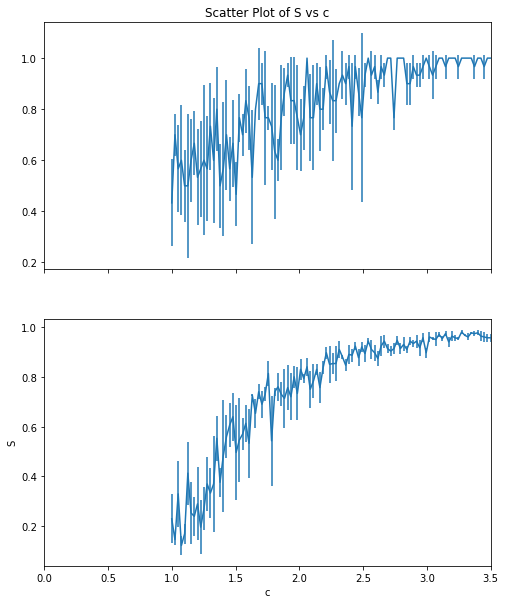

In [13]:
N = [10, 100, 1000]
N = [10, 100] # Becouse of grading...
C = linspace(1,3.5,100)

numiterations = 3
fig, axes = plt.subplots(size(N), 1, sharex = True)
for i,n in enumerate(N):
    S = []
    Serror = []
    for c in C:
        p = c / (n-1)
        s = []
        for j in range(numiterations):
            G = nx.erdos_renyi_graph(n, p)
            s.append(len(max(nx.connected_components(G), key=len)) / n)
        S.append(average(s))
        Serror.append(std(s))
    axes[i].errorbar(C, S, yerr=Serror)
    
    plt.xlim(0,3.5)
    plt.xlabel('c')
    plt.ylabel('S')
    
axes[0].set_title('Scatter Plot of S vs c')
fig.set_size_inches(8,10)
plt.show()

It is pretty obvious when looking at the progression of these plots that it is converging apon the expected relationship between c and S. Just in general this is a thing that happens with statistics... ever heard of "law of large numbers"?

## Degree Distributions of Random Network Models
For this section each of these models is plotted and the graphs themselve have the information of what that plot is and what the associated alpha is...

### Erdos-Renyi

alpha = 14.82 +/- 0.62
alpha = 10.62 +/- 0.30
alpha = 18.60 +/- 0.56


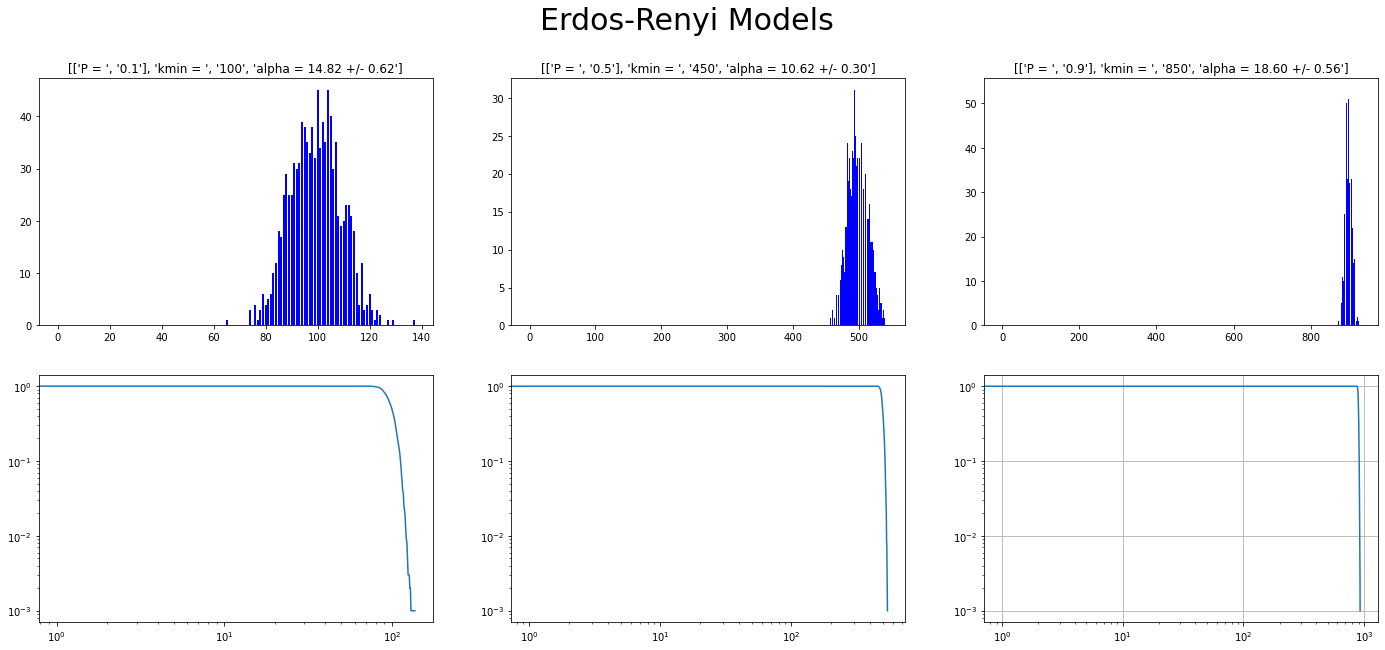

In [15]:
N = [1000]
P = [0.1, 0.5, 0.9]
kmin = [[100, 450, 850]]

i = 0
fig, axes = plt.subplots(2*size(N), size(P))
for i, n in enumerate(N):
    for j, p in enumerate(P):
        G = nx.erdos_renyi_graph(n,p) ##################### Change this
        calc_powerlaw(G,kmin[i][j],[axes[2*i,j],axes[2*i+1,j]],['P = ',str(p)])
    
fig.set_size_inches(size(P)*8,size(N)*10)
fig.suptitle('Erdos-Renyi Models', fontsize = 30) ########### Change This
plt.show()

### Small-World

alpha = 14.02 +/- 0.87
alpha = 54.80 +/- 7.13
alpha = 91.06 +/- 5.62
alpha = 25.76 +/- 2.38
alpha = 48.39 +/- 8.51
alpha = 64.09 +/- 3.26
alpha = 13.49 +/- 0.58
alpha = 41.97 +/- 2.63
alpha = 41.70 +/- 1.88


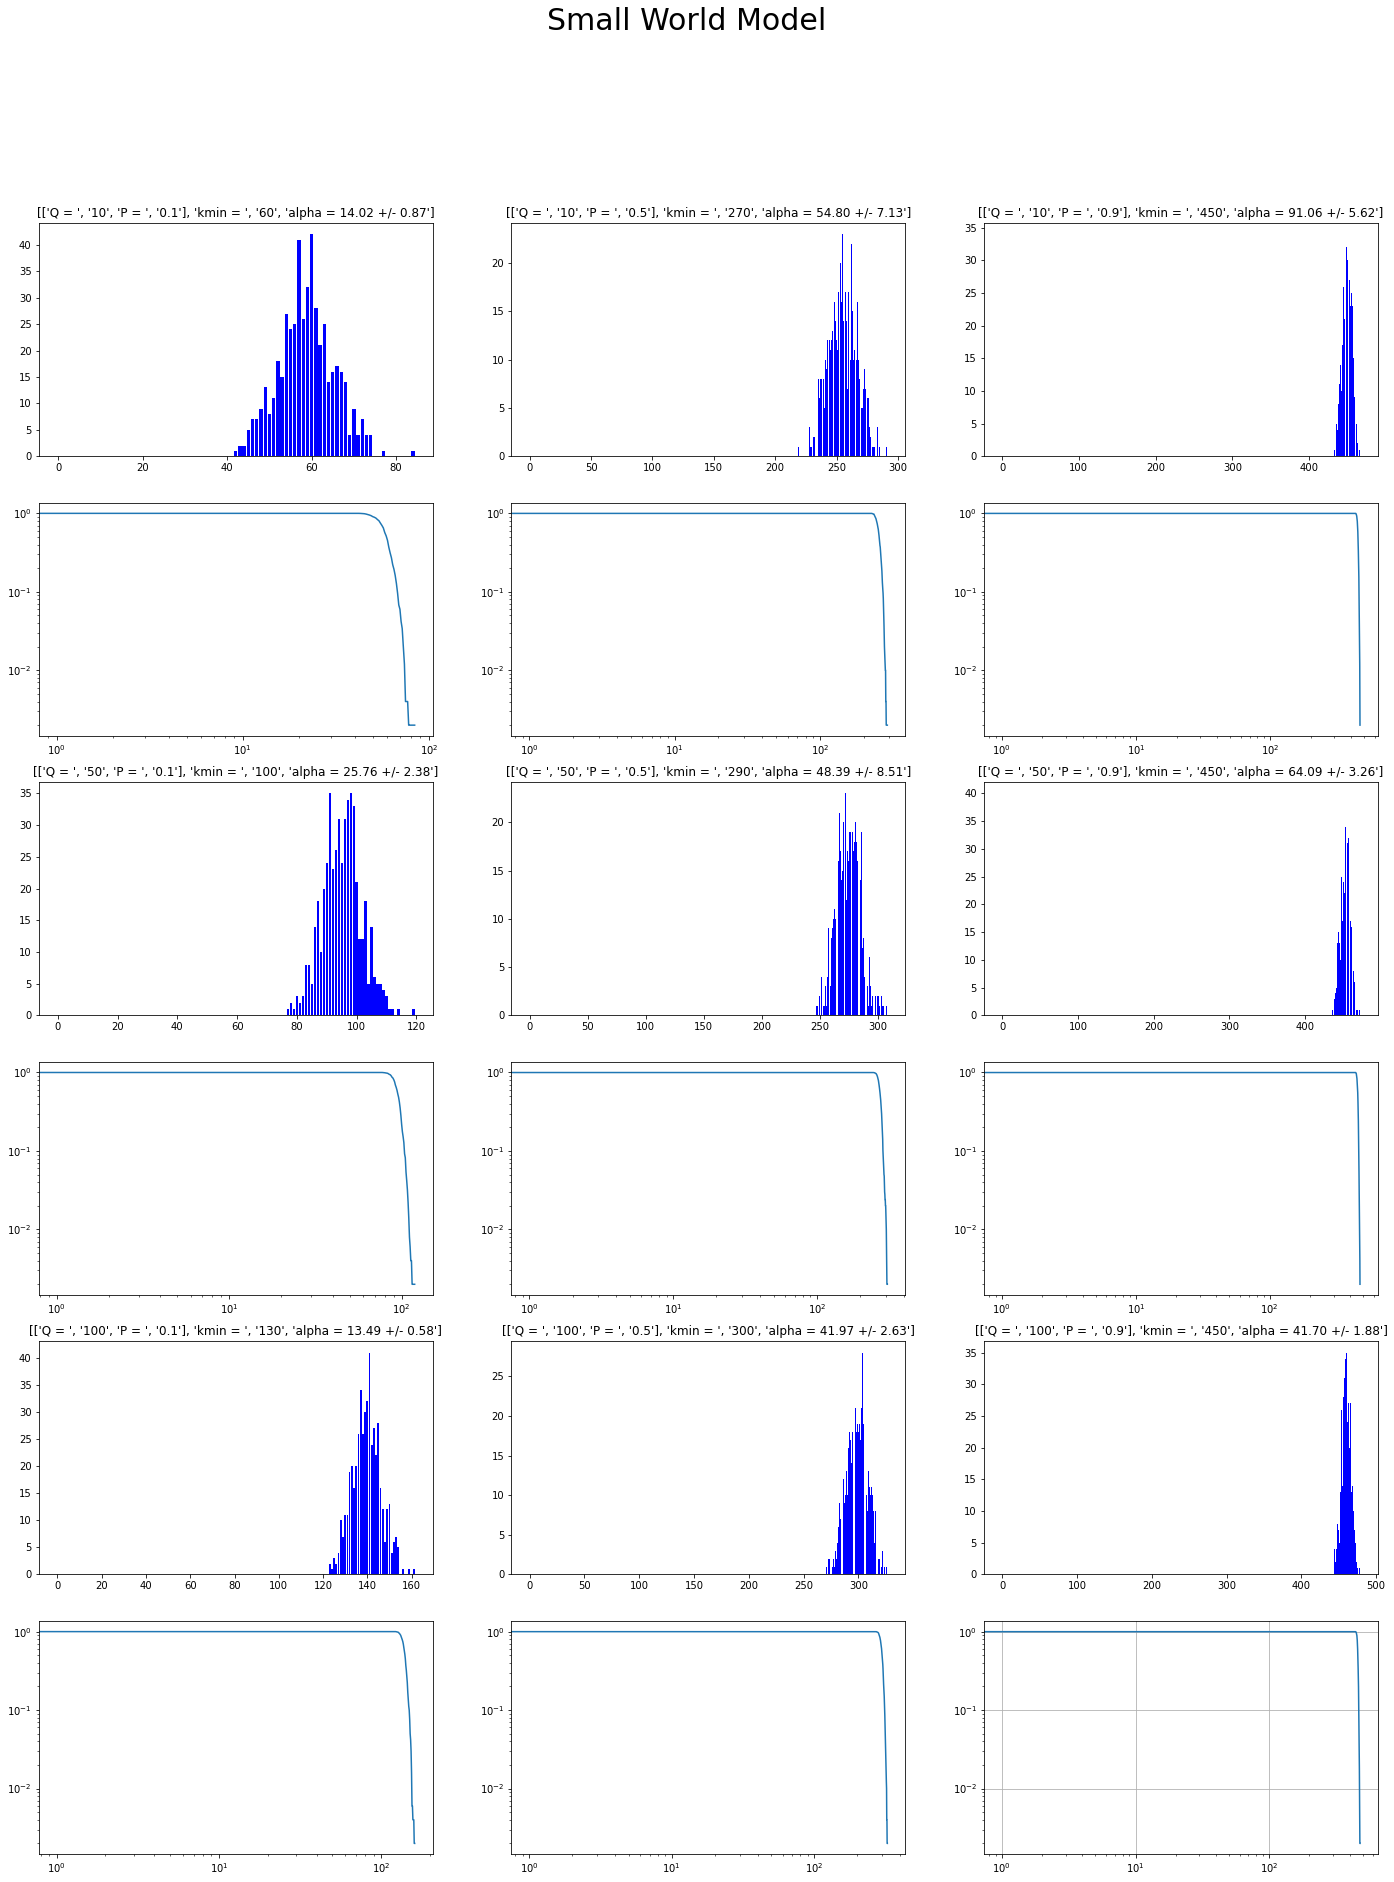

In [16]:
N = [500] #5000 way too high
Q = [10, 50, 100]
P = [0.1, 0.5, 0.9]
kmin = [[60,270,450],[100,290,450], [130,300,450]]

n = N[0]
fig, axes = plt.subplots(2*size(Q), size(P))
for i, q in enumerate(Q):
    for j, p in enumerate(P):
        G = randomnet.small_world_graph(n,q,p) ##################### Change this
        calc_powerlaw(G,kmin[i][j],[axes[2*i,j],axes[2*i+1,j]], ['Q = ', str(q), 'P = ', str(p)])
    
fig.set_size_inches(size(P)*8,size(Q)*10)
fig.suptitle('Small World Model', fontsize = 30) ########### Change This
plt.show()

### Barabasi-Albert

alpha = 2.86 +/- 0.03
alpha = 2.93 +/- 0.04
alpha = 2.91 +/- 0.03


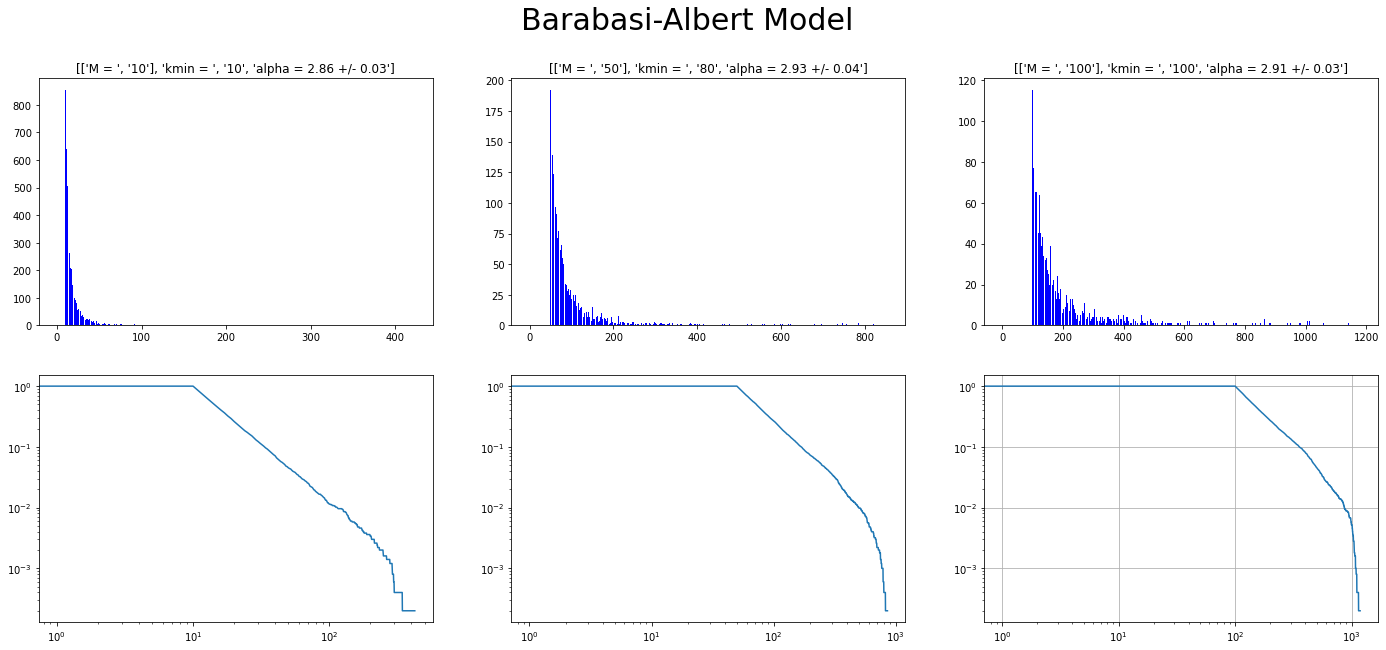

In [17]:
N = [5000]
M = [10, 50, 100]
kmin = [[10, 80, 100]]

fig, axes = plt.subplots(2*size(N), size(M))
for i, n in enumerate(N):
    for j, m in enumerate(M):
        G = nx.barabasi_albert_graph(n,m) ##################### Change this
        calc_powerlaw(G,kmin[i][j],[axes[2*i,j],axes[2*i+1,j]], ['M = ', str(m)])
    
fig.set_size_inches(size(M)*8,size(N)*10)
fig.suptitle('Barabasi-Albert Model', fontsize = 30) ########### Change This
plt.show()

### Local Attachment

alpha = 4.62 +/- 0.16
alpha = 3.50 +/- 0.11
alpha = 2.81 +/- 0.08
alpha = 2.26 +/- 0.09
alpha = 2.48 +/- 0.09
alpha = 2.76 +/- 0.09
alpha = 2.91 +/- 0.09
alpha = 2.76 +/- 0.08
alpha = 2.68 +/- 0.07


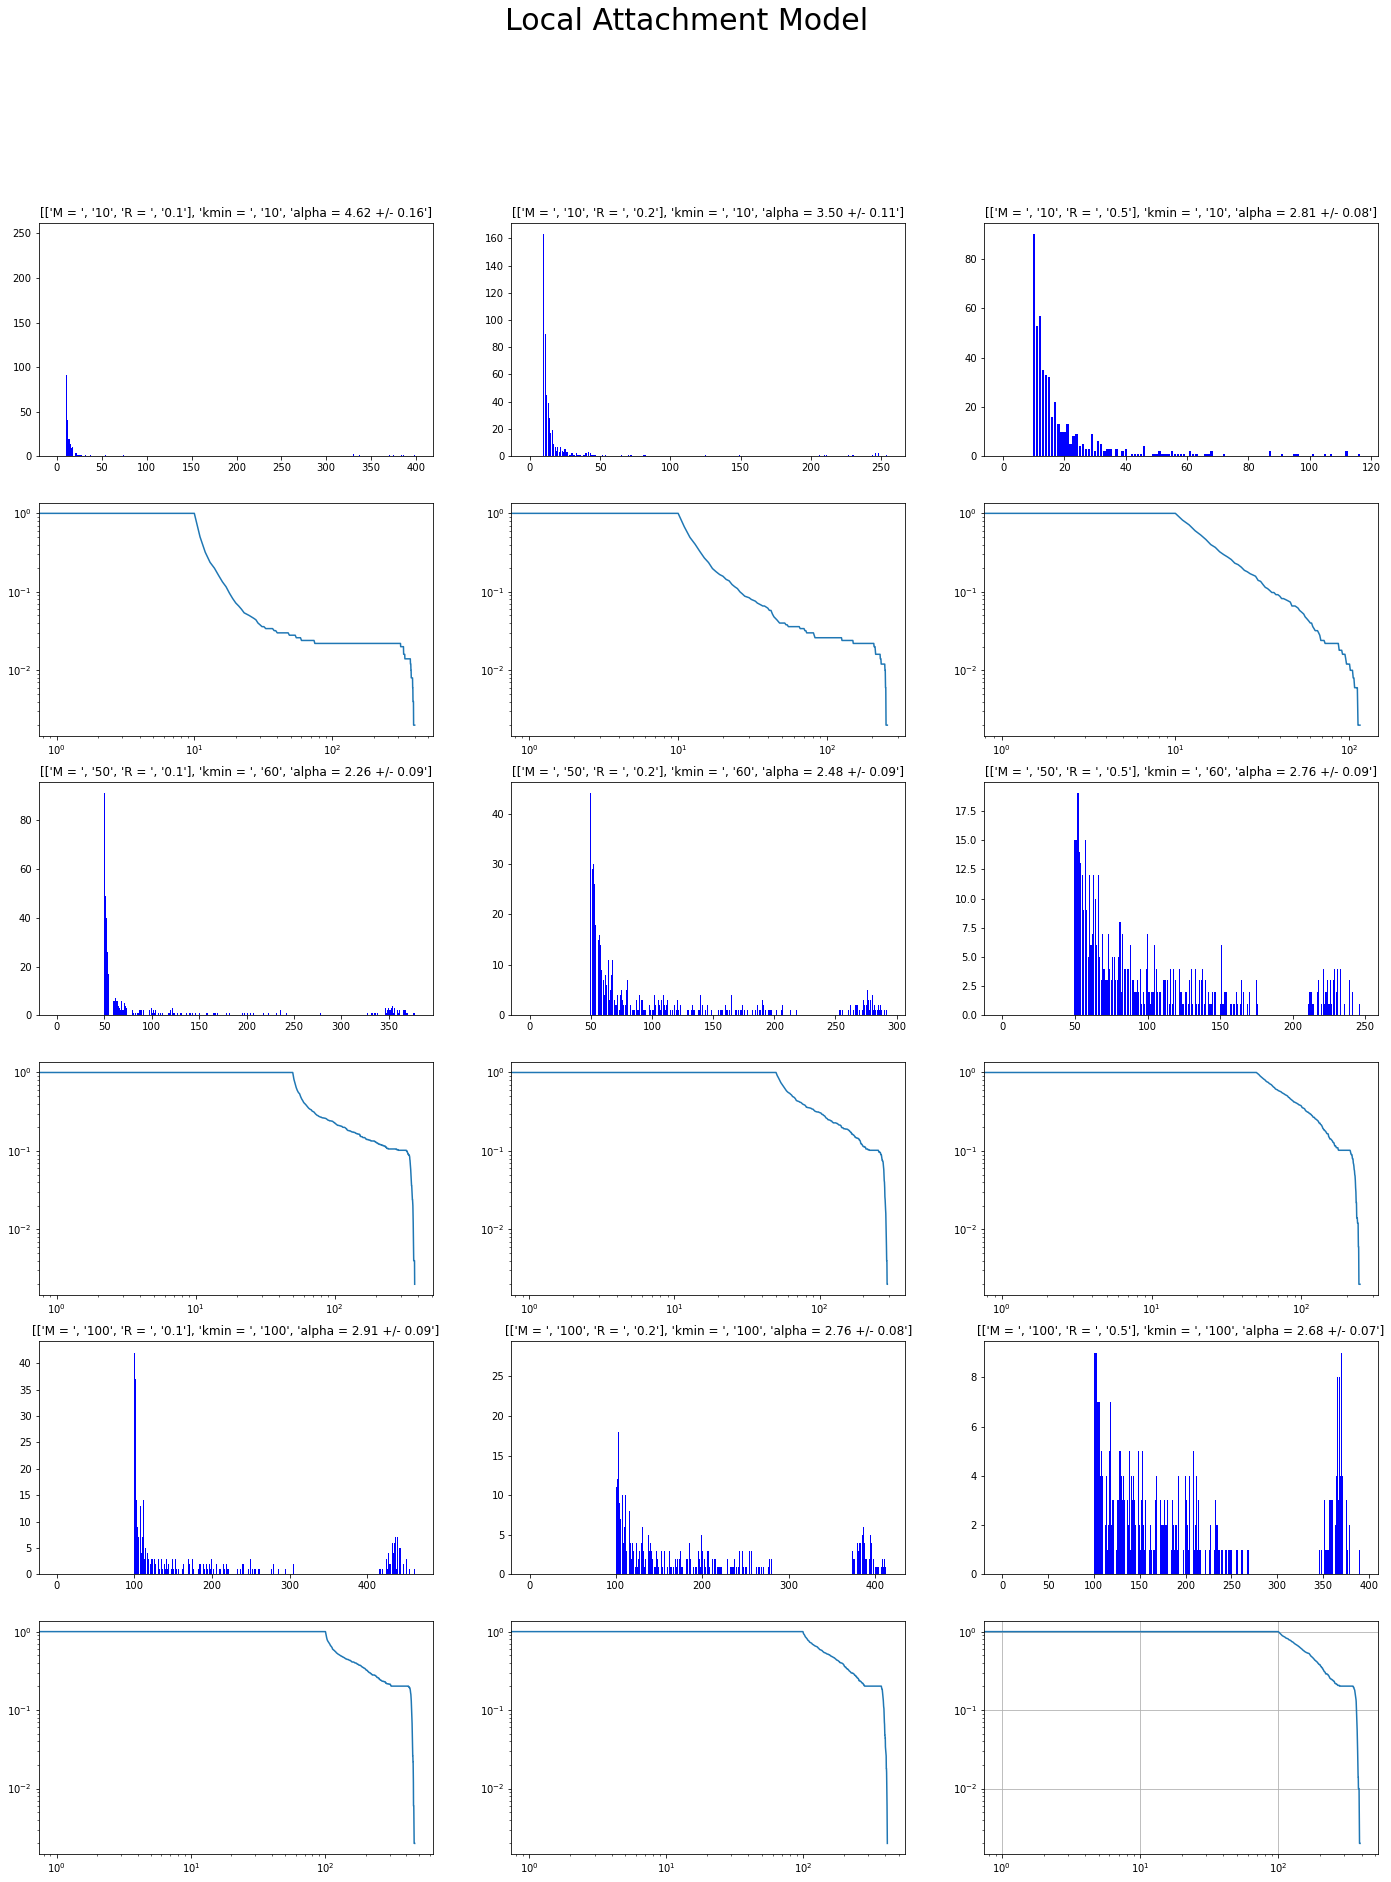

In [22]:
N = [500] #Had to make smaller for speed
M = [10, 50, 100]
R = [0.1, 0.2, 0.5] # relative to M
kmin = [[10, 10, 10],[60, 60, 60], [100, 100, 100]]

n = N[0]
fig, axes = plt.subplots(2*size(R), size(M))#size(R))
for i, m in enumerate(M):
    for j, r in enumerate(R):
        G = randomnet.local_attachment_graph(n,m,int(r * m)) ##################### Change this
        calc_powerlaw(G,kmin[i][j],[axes[2*i,j],axes[2*i+1,j]], ['M = ', str(m), 'R = ', str(r)])
    
fig.set_size_inches(size(R)*8,size(M)*10)
fig.suptitle('Local Attachment Model', fontsize = 30) ########### Change This
plt.show()

### Duplication Divergence

alpha = 1.82 +/- 0.01
alpha = 1.42 +/- 0.01
alpha = 1.56 +/- 0.01
alpha = 1.61 +/- 0.01


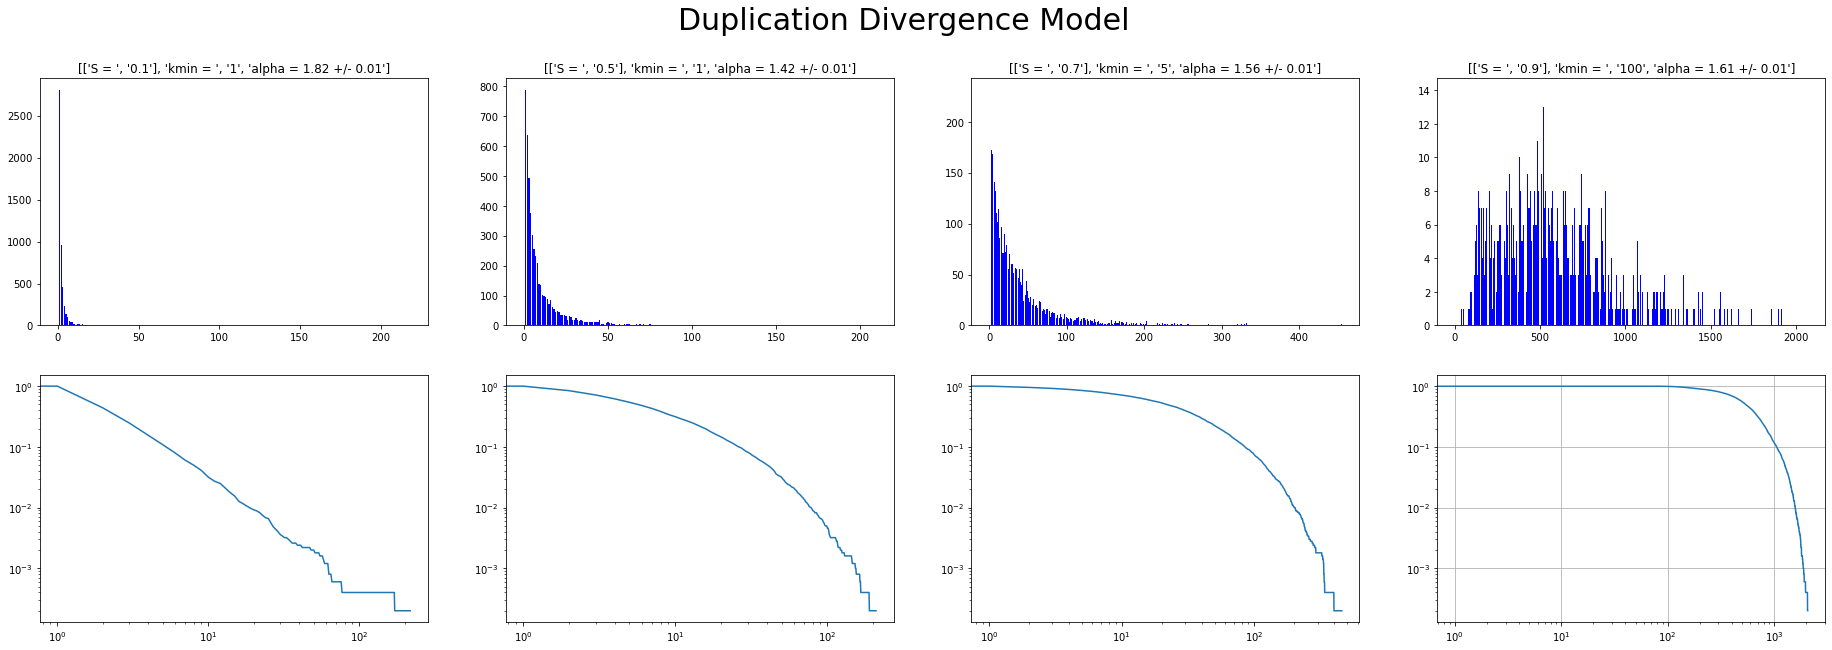

In [23]:
N = [5000]
S = [0.1, 0.5, 0.7, 0.9]
kmin = [[1, 1, 5, 100]]

i = 0
fig, axes = plt.subplots(2*size(N), size(S))
for i, n in enumerate(N):
    for j, s in enumerate(S):
        G = nx.duplication_divergence_graph(n,s) ##################### Change this
        calc_powerlaw(G,kmin[i][j],[axes[2*i,j],axes[2*i+1,j]], ['S = ', str(s)])
    
fig.set_size_inches(size(S)*8,size(N)*10)
fig.suptitle('Duplication Divergence Model', fontsize = 30) ########### Change This
plt.show()

## Fitting Random Models

In [38]:
G = nx.read_weighted_edgelist('ca-HepTh.edgelist')
n = G.number_of_nodes()
m = G.number_of_edges()

degSeq = degree_sequence(G)
ddist = degree_distribution(G,False)
cdist = cumulative_degree_distribution(G)
avgDeg = average(degSeq)
avgClst = nx.average_clustering(G)

kmin = 1

#### Degree Dist Plot

alpha = 1.53 +/- 0.01


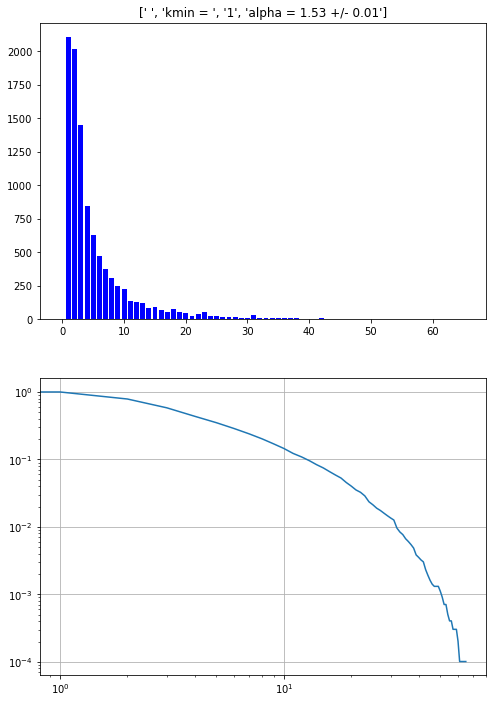

In [39]:
alpha = calc_powerlaw(G,kmin)
plt.show()

#### ER Equivelent

alpha = 1.36 +/- 0.01


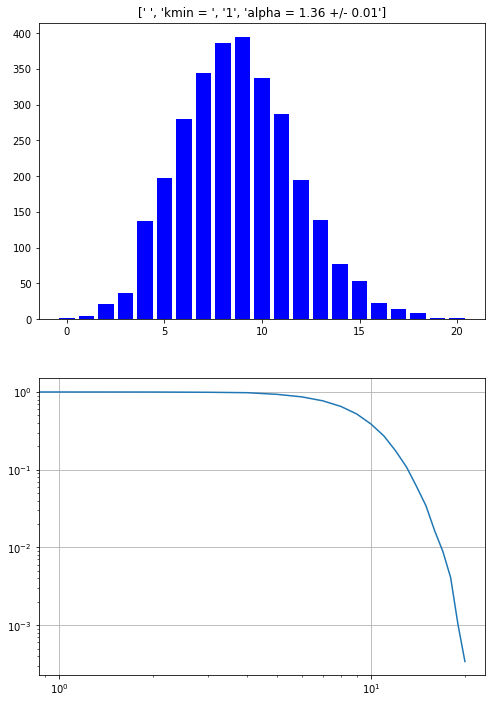

In [78]:
n_ER = n
p_ER = 0.003
G_ER = nx.erdos_renyi_graph(n_ER,p_ER)

alpha_ER = calc_powerlaw(G_ER,kmin)
plt.show()

degSeq_ER = degree_sequence(G_ER)
ddist_ER = degree_distribution(G_ER,False)
cdist_ER = cumulative_degree_distribution(G_ER)
avgDeg_ER = average(degSeq_ER)
avgClst_ER = nx.average_clustering(G_ER)

#### LA Equivelent

alpha = 1.22 +/- 0.00


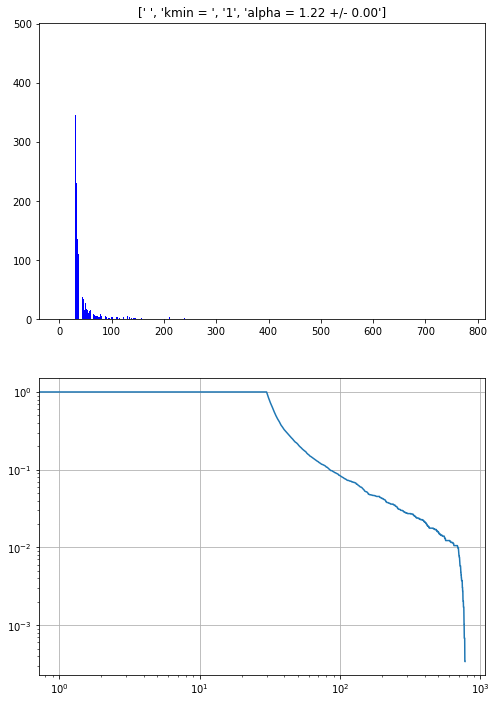

In [95]:
n_LA = n
m_LA = 30
r_LA = int(ceil(m_LA * 0.15))
G_LA = randomnet.local_attachment_graph(n_LA,m_LA,r_LA) # This is REALLY Inefficent!!!!!

alpha_LA = calc_powerlaw(G_LA,kmin)
plt.show()


degSeq_LA = degree_sequence(G_LA)
ddist_LA = degree_distribution(G_LA,False)
cdist_LA = cumulative_degree_distribution(G_LA)
avgDeg_LA = average(degSeq_LA)
avgClst_LA = nx.average_clustering(G_LA)

#### DD Equivelent

alpha = 1.74 +/- 0.01


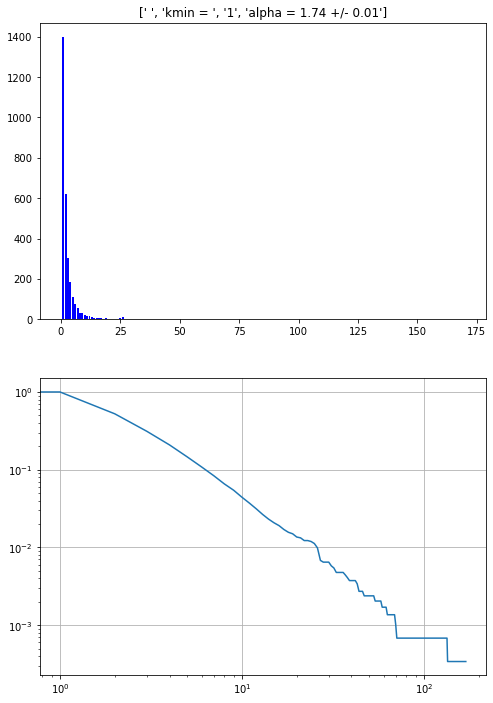

In [97]:
n_DD = n
s_DD = 0.18
G_DD = G = nx.duplication_divergence_graph(n_DD,s_DD)

alpha_DD = calc_powerlaw(G_DD,kmin)
plt.show()

degSeq_DD = degree_sequence(G_DD)
ddist_DD = degree_distribution(G_DD,False)
cdist_DD = cumulative_degree_distribution(G_DD)
avgDeg_DD = average(degSeq_DD)
avgClst_DD = nx.average_clustering(G_DD)

#### Comparrision

Overall this comparrison indicates that my statistics are actually pretty terrible...

In [98]:
compArray = array([
    [n, avgDeg, avgClst, alpha],
    [n_ER, avgDeg_ER, avgClst_ER, alpha_ER],
    [n_LA, avgDeg_LA, avgClst_LA, alpha_LA],
    [n_DD, avgDeg_DD, avgClst_DD, alpha_DD]
]).T

import pandas as pd

df = pd.DataFrame(compArray,
                  columns = ['ca-HelpTH', 'ER', 'LA', 'DD'],
                  index = ['n', 'Average Degree', 'Average Cluster Degree', 'Alpha'])
display(df)

,ca-HelpTH,ER,LA,DD
n,2939.000000,2939.000000,2939.000000,2939.000000
Average Degree,10.668255,8.772372,60.000000,3.028241
Average Cluster Degree,0.452634,0.003612,0.139299,0.000000
Alpha,1.481819,1.357039,1.223987,1.740994


## Configuration Model

In [71]:
def average_neighbor_degree(G):
    sumDeg = 0
    for n, deg in G.degree:
        nbr_deg = [d for n, d in G.degree(G[n])]
        deg = len(nbr_deg)
        if deg == 0:
            deg = 1
        sumDeg += sum(nbr_deg) / float(deg)
    avgDeg = sumDeg / size(G.degree)
    return avgDeg

#### Texas Road Sample

alpha = 1.67 +/- 0.01
Average Degree = 2.50, Average Neighbor Degree = 1.49


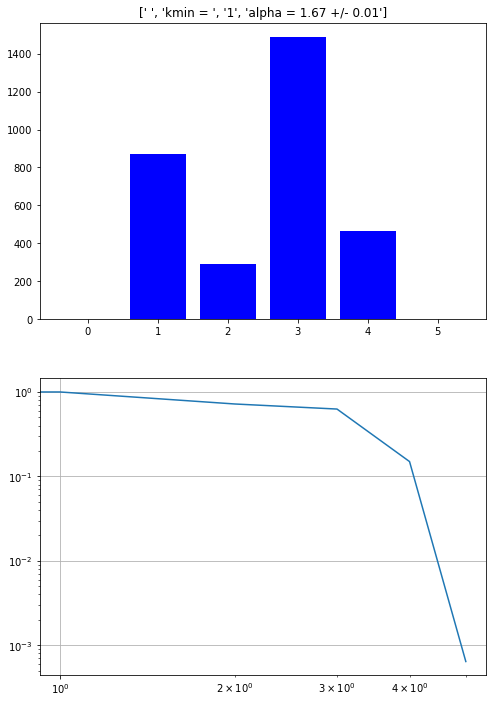

In [72]:
G = nx.read_weighted_edgelist('texas_road_sample.edgelist')
n = G.number_of_nodes()
m = G.number_of_edges()

degSeq = degree_sequence(G)
ddist = degree_distribution(G,False)
cdist = cumulative_degree_distribution(G)
avgDeg = average(degSeq)
avgNbrDeg = average_neighbor_degree(G)
avgClst = nx.average_clustering(G)

kmin = 1
alpha = calc_powerlaw(G,kmin)

print('Average Degree = %1.2f, Average Neighbor Degree = %1.2f' % (avgDeg,avgNbrDeg))

plt.show()

#### International Airports

alpha = 1.48 +/- 0.01
Average Degree = 10.67, Average Neighbor Degree = 22.53


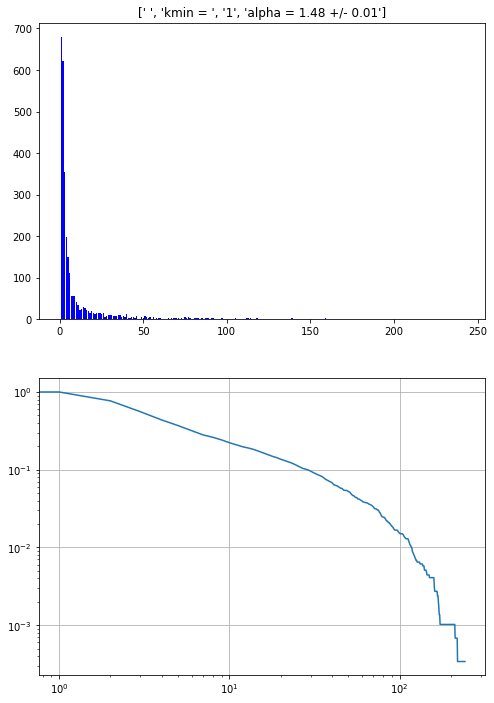

In [73]:
G = nx.read_weighted_edgelist('international_airports.edgelist')
n = G.number_of_nodes()
m = G.number_of_edges()

degSeq = degree_sequence(G)
ddist = degree_distribution(G,False)
cdist = cumulative_degree_distribution(G)
avgDeg = average(degSeq)
avgNbrDeg = average_neighbor_degree(G)
avgClst = nx.average_clustering(G)

kmin = 1
alpha = calc_powerlaw(G,kmin)

print('Average Degree = %1.2f, Average Neighbor Degree = %1.2f' % (avgDeg,avgNbrDeg))

plt.show()

#### Comparrison

This is likely due to how each of the connections between points are. In the road case, there are usully only so many roads (4) that can come into an intersections, so there is less likely for there to be any hubs that exist. On the other hand, airport networks are often built on the hub network structure to decrease the overall number of flights and make connections instead.